In [2]:
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [4]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [6]:
# pytorch helpfully makes it easy to download datasets, e.g. the common CIFAR-10 https://www.kaggle.com/c/cifar-10
ROOT = './'
train_data = torchvision.datasets.MNIST(os.path.join(ROOT, 'data'), train=True, transform=None, target_transform=None, download=True)
test_data  = torchvision.datasets.MNIST(os.path.join(ROOT, 'data'), train=False, transform=None, target_transform=None, download=True)
print(len(train_data), len(test_data))

60000 10000


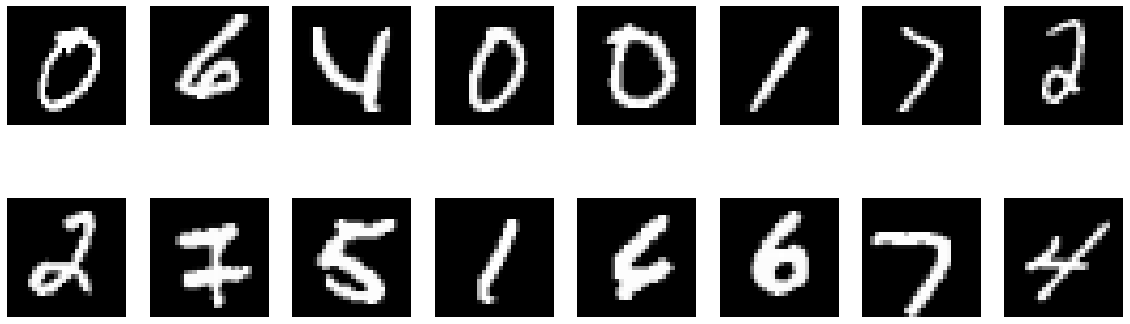

In [27]:
# encode the training examples with our codebook to visualize how much we've lost in the discretization
n_samples = 16
ncol = 8
nrow = n_samples // ncol + 1
plt.figure(figsize=(20, 10))
for i in range(n_samples):
    
    # encode and decode random data
    x, y = train_data[np.random.randint(0, len(train_data))]
    x = torch.from_numpy(np.array(x))
    
    # these images should look normal ideally
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(x.view(28, 28, 1).numpy().astype(np.uint8), cmap='gray')
    plt.axis('off')

In [8]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    """
    Custom dataset of MNIST for Transformer
    """
    
    def __init__(self, pt_dataset, H=28, W=28, perm=None):
        self.pt_dataset = pt_dataset
        self.perm = torch.arange(28*28) if perm is None else perm       
        self.block_size = 28*28 - 1
        self.vocab_size = 256  # 8bit-gray
        
    def __len__(self):
        return len(self.pt_dataset)

    def __getitem__(self, idx):
        x, y = self.pt_dataset[idx]
        x = torch.from_numpy(np.array(x)).view(-1)
        x = x[self.perm].to(dtype=torch.int64)
        return x[:-1], x[1:] # always just predict the next one in the sequence

train_dataset = ImageDataset(train_data, H=28, W=28)
test_dataset = ImageDataset(test_data, H=28, W=28)
train_dataset[0][0] # one example image flattened out into integers

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
         18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 1

In [9]:
from mingpt.model import GPT, GPTConfig, GPT1Config

# very very small transformer
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  embd_pdrop=0.0, resid_pdrop=0.1, attn_pdrop=0.0,
                  n_layer=4, n_head=8, n_embd=256)
model = GPT(mconf)

02/16/2021 06:10:24 - INFO - mingpt.model -   number of parameters: 3.491072e+06


In [14]:
from mingpt.trainer import Trainer, TrainerConfig

tokens_per_epoch = len(train_data) * train_dataset.block_size
train_epochs = 5 # todo run a bigger model and longer, this is tiny
model_path = os.path.join(ROOT, 'model', datetime.now().strftime('%Y%m%d_%H%M%S'))
if not os.path.exists(model_path):
    os.makedirs(model_path)

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=train_epochs, batch_size=32, learning_rate=3e-3,
                      betas=(0.9, 0.95), weight_decay=1e-4,
                      lr_decay=True, warmup_tokens=tokens_per_epoch, final_tokens=train_epochs*tokens_per_epoch,
                      ckpt_path=os.path.join(model_path, 'mnist_model.pt'),
                      num_workers=8)
trainer = Trainer(model, train_dataset, test_dataset, tconf)
trainer.train()

In [10]:
# load the state of the best model we've seen based on early stopping
# checkpoint = torch.load(os.path.join(model_path, 'mnist_model.pt'))
checkpoint = torch.load(os.path.join('/prml2021w/prml003/model/20210216_060254', 'mnist_model.pt'))
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [12]:
# to sample we also have to technically "train" a separate model for the first token in the sequence
# we are going to do so below simply by calculating and normalizing the histogram of the first token
counts = torch.ones(256) # start counts as 1 not zero, this is called "smoothing"
rp = torch.randperm(len(train_dataset))
nest = 5000 # how many images to use for the estimation
for i in range(nest):
    a, _ = train_dataset[int(rp[i])]
    t = a[0].item() # index of first token in the sequence
    counts[t] += 1
prob = counts/counts.sum()

In [15]:
%%time

from mingpt.utils import sample

n_samples = 32
start_pixel = np.random.choice(np.arange(256), size=(n_samples, 1), replace=True, p=prob)
start_pixel = torch.from_numpy(start_pixel).to(trainer.device)
pixels = sample(model, start_pixel, 28*28-1, temperature=1.0, sample=True, top_k=100)

CPU times: user 13 s, sys: 6.38 s, total: 19.3 s
Wall time: 36.7 s


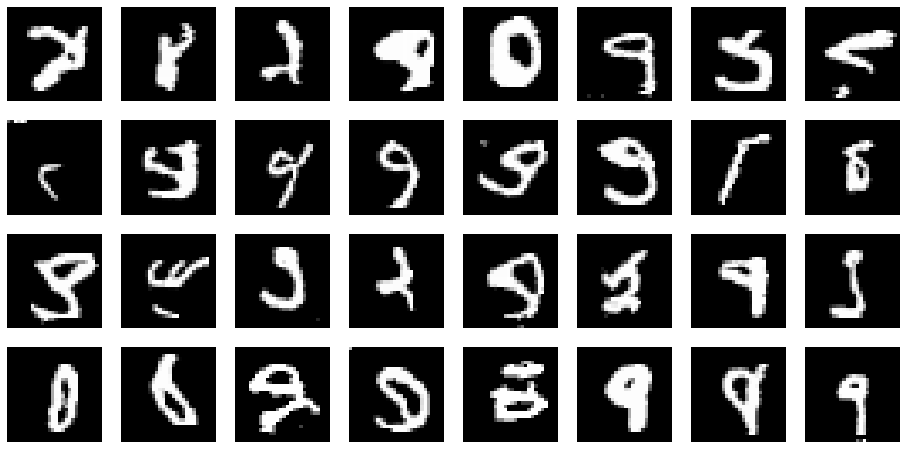

In [26]:
# for visualization we have to invert the permutation used to produce the pixels
iperm = torch.argsort(train_dataset.perm)

ncol = 8
nrow = n_samples // ncol
plt.figure(figsize=(16, 8))
for i in range(n_samples):
    pxi = pixels[i][iperm] # note: undo the encoding permutation
    
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(pxi.view(28, 28, 1).cpu().numpy().astype(np.uint8), cmap='gray')
    plt.axis('off')